In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import numpy as np
import optuna
from dataclasses import dataclass
import datetime

optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.alpha'] = 0.3

# Supuestos

+ Comisión = 0.125%
+ No hay impuestos
+ No apalancamiento
+ Cuenta Margen = 50%
+ Capital = 1,000,000
+ N Shares = 50
+ Stop Loss / Take Profit = 6%
+ Trades at Close
+ Borrow Rate 0.25%

In [2]:
@dataclass
class Position:
    """
    Represents a trading position.
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

def get_portfolio_value(capital, long_positions, current_price, n_shares):
    # Long positions are valued at current market price
    value = capital
    value += len(long_positions) * n_shares * current_price

    return value

def print_results(capital, initial_capital, portfolio_values,
                  rsi_lower, rsi_upper, com, stop_loss, take_profit, n_shares,
                  initial_margin, maint_margin, borrow_rate, adj_borrow_rate):
    print('----------- Bactesting Results -----------')
    print('******************************************\n')

    print(f'RSI Limits: Buy below {rsi_lower}, Sell above {rsi_upper}')
    print(f'Commission per trade: {com*100:.3f}%')
    print(f'Stop Loss: {stop_loss*100:.2f}%')
    print(f'Take Profit: {take_profit*100:.2f}%')
    print(f'Number of Shares per Trade: {n_shares}')
    print(f'Margin Account Requirement: {initial_margin*100:.2f}%')
    print(f'Maintenance Margin Requirement: {maint_margin*100:.2f}%')
    print(f'Annual Borrow Rate: {borrow_rate*100:.3f}%')
    print(f'Adjusted Borrow Rate per 5 min: {adj_borrow_rate*100:.6f}%\n')

    print(f'Initial Capital: ${initial_capital:,.2f}')
    print(f'Final Capital: ${capital:,.2f}')
    print(f'Net Profit: ${capital - initial_capital:,.2f}')
    print(f'Return on Investment: {(capital - initial_capital) / initial_capital * 100:,.2f}%')
    print('\n******************************************')
    print('------------------------------------------')

    plt.figure()
    plt.plot(portfolio_values, label='Portfolio Value', color='cadetblue')
    plt.title('Portfolio Value Over Time')
    plt.show()

In [3]:
data = pd.read_csv('../data/Binance_BTCUSDT_1h.csv').dropna()
data[['Date', 'Hour']] = data['Date'].str.split(' ', expand=True)
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Hour'], format='%d/%m/%y %H:%M')
data.set_index('Datetime', inplace=True)
data.drop(columns=['Date', 'Hour', 'Unix'], inplace=True)
data.sort_index(inplace=True)
data = data[~data.index.isnull()]

n = len(data)
train_end = int(n*0.6)
test_end = int(n*(0.6 + 0.2))

train_data = data.iloc[:train_end].copy()
test_data = data.iloc[train_end:test_end].copy()
validation_data = data.iloc[test_end:].copy()

# Optuna Optimization

In [4]:
def objective(trial, data):
    data = data.copy()

    # Hyperparameters to optimize
    rsi_window = trial.suggest_int('rsi_window', 8, 80)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    #rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 5, 500)

    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()
    data['buy_signal'] = data['rsi'] < rsi_lower
    #data['sell_signal'] = data['rsi'] > rsi_upper
    data = data.dropna()

    COM = 0.125/100

    STOP_LOSS = stop_loss
    TAKE_PROFIT = take_profit
    N_SHARES = n_shares

    capital = 1_000_000
    portfolio_value = [capital]

    active_long_positions: list[Position] = []
    

    for i, row in data.iterrows():
        # -- LONG ACTIVE ORDERS -- #
        for position in active_long_positions.copy():
            # Stop Loss or take profit Check
            if row.Close > position.tp or row.Close < position.sl:
                # Add profits / losses to capital
                capital += row.Close * position.n_shares * (1-COM)
                #Remove position from active pos
                active_long_positions.remove(position)

        # -- LONG -- #
        # Check Signal
        if row.buy_signal:
            cost = row.Close * N_SHARES * (1 + COM)
            # Do we have enough capital cash?
            if capital > cost:
                # Discount cash
                capital -= cost
                # Add position to portfolio
                pos = Position(
                    ticker='AAPL',
                    n_shares=N_SHARES,
                    price=row['Close'],
                    sl=row['Close'] * (1 - STOP_LOSS),
                    tp=row['Close'] * (1 + TAKE_PROFIT),
                    time=row.index
                )
                active_long_positions.append(pos)

        portfolio_value.append(get_portfolio_value(capital, active_long_positions, row.Close, N_SHARES))

    #At the end of the backtesting, we should close all active positions
    capital += row.Close * len(active_long_positions) * N_SHARES * (1-COM)
    active_long_positions = []

    df = pd.DataFrame()
    df['Value'] = portfolio_value
    df['rets'] = df.Value.pct_change()
    df.dropna(inplace=True)

    mean = df.rets.mean()
    std = df.rets.std()
    down_risk = df.rets[df.rets < 0].fillna(0).std()

    annual_rets = mean * 365 * 24
    annual_std = std * np.sqrt(365 * 24)
    annual_down_risk = down_risk * np.sqrt(365 * 24)

    #return annual_rets / annual_down_risk if annual_std != 0 else 0 #MAX SORTINO RATIO
    return annual_rets / annual_std if annual_std != 0 else 0 #MAX SHARPE RATIO
    #return (capital / 1_000_000) - 1  # MAX NET PROFIT

In [5]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_data), n_trials=50, n_jobs=1, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
study.best_params

{'rsi_window': 12,
 'rsi_lower': 32,
 'stop_loss': 0.048334488773129736,
 'take_profit': 0.14879077835346266,
 'n_shares': 202}

In [7]:
study.best_value

0.9963878161182506

# Backtest with optimized hyperparameters

In [8]:
rsi_window = study.best_params['rsi_window']
rsi_lower = study.best_params['rsi_lower']
#rsi_upper = study.best_params['rsi_upper']
STOP_LOSS = study.best_params['stop_loss']
TAKE_PROFIT = study.best_params['take_profit']
N_SHARES = study.best_params['n_shares']

INITIAL_MARGIN = 0.5
MAINT_MARGIN = 0.3
BORROW_RATE = 0.0125
ADJ_BORROW_RATE = BORROW_RATE / (252 * 6.5 * 60 / 5)

COM = 0.125/100

In [9]:
rsi_window, rsi_lower, STOP_LOSS, TAKE_PROFIT, N_SHARES

(12, 32, 0.048334488773129736, 0.14879077835346266, 202)

In [10]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)

data['rsi'] = rsi_indicator.rsi()
data['buy_signal'] = data['rsi'] < rsi_lower
#data['sell_signal'] = data['rsi'] > rsi_upper
data = data.dropna()

----------- Bactesting Results -----------
******************************************

RSI Limits: Buy below 32, Sell above nan
Commission per trade: 0.125%
Stop Loss: 4.83%
Take Profit: 14.88%
Number of Shares per Trade: 202
Margin Account Requirement: 50.00%
Maintenance Margin Requirement: 30.00%
Annual Borrow Rate: 1.250%
Adjusted Borrow Rate per 5 min: 0.000064%

Initial Capital: $1,000,000.00
Final Capital: $6,573,095.00
Net Profit: $5,573,095.00
Return on Investment: 557.31%

******************************************
------------------------------------------


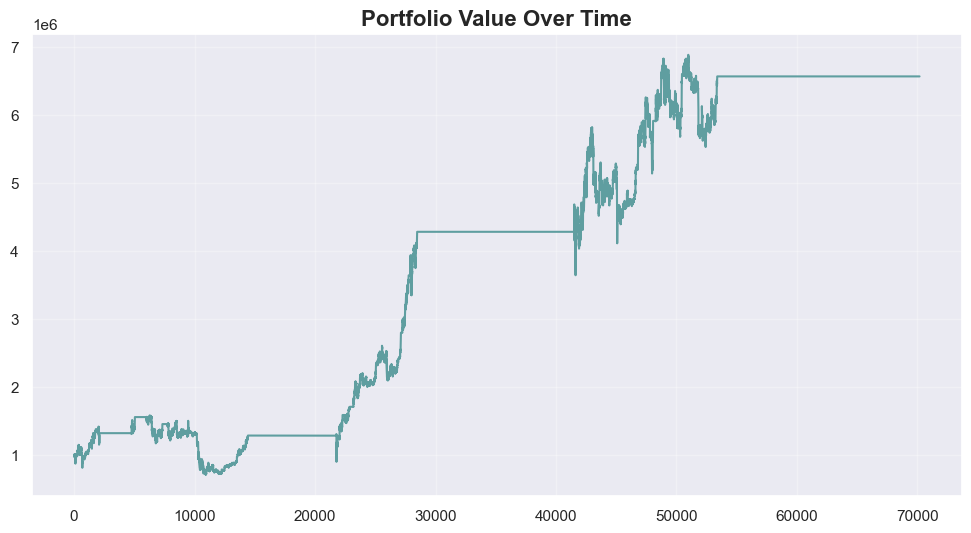

In [11]:
capital = 1_000_000
active_long_positions: list[Position] = []
portfolio_values = [capital]

for i, row in data.iterrows():
    # -- LONG ACTIVE ORDERS -- #
    for position in active_long_positions.copy():
        # Stop Loss or take profit Check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1-COM)
            #Remove position from active pos
            active_long_positions.remove(position)

    # -- LONG -- #
    # Check Signal
    if row.buy_signal:
        cost = row.Close * N_SHARES * (1 + COM)
        # Do we have enough capital cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(
                ticker='AAPL',
                n_shares=N_SHARES,
                price=row['Close'],
                sl=row['Close'] * (1 - STOP_LOSS),
                tp=row['Close'] * (1 + TAKE_PROFIT),
                time=row.index
            )
            active_long_positions.append(pos)

    portfolio_values.append(get_portfolio_value(capital, active_long_positions, row.Close, N_SHARES))

#At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1-COM)
active_long_positions = []

print_results(capital, 1_000_000, portfolio_values,
              rsi_lower, np.NaN, COM, STOP_LOSS, TAKE_PROFIT,
              N_SHARES, INITIAL_MARGIN, MAINT_MARGIN, BORROW_RATE, ADJ_BORROW_RATE)

In [12]:
df = pd.DataFrame()
df['Value'] = portfolio_values
df['rets'] = df.Value.pct_change()
df.dropna(inplace=True)

mean = df.rets.mean()
std = df.rets.std()
down_risk = df.rets[df.rets < 0].fillna(0).std()

annual_rets = mean * (60 * 6.5 * 252 / 5)
annual_std = std * np.sqrt(60 * 6.5 * 252 / 5)
annual_down_risk = down_risk * np.sqrt(60 * 6.5 * 252 / 5)

print(f'Sharpe Ratio: {annual_rets / annual_std:,.4f}')
print(f'Sortino Ratio: {annual_rets / annual_down_risk:,.4f}')

Sharpe Ratio: 1.2712
Sortino Ratio: 0.9305
